### IF you guys have any suggestions at all, or better way to do this, or do not want to do this way, please speak up, we can do it that way too.
#### Hey Guys! If everyone is okay, this will be our main document.
#### Remember to pull before you start working.
#### I will recommend that each of us have two copies of this ipynb.
#### One will be your personal, whatever work you do will be there. It will serve as scratchpad of sorts.
#### Once you are done, you can do git pull, copy paste your work in the main document, beautify it and then push. This way we wont have any trouble with version controlling.


Project checkpoint 1 (15%): For this milestone, you will need to have downloaded the data, and
also run some initial pre-processing on it. You should also make at least one dummy submission
(all-positive, all-negative, most-frequency) on Kaggle and submit the Jupyter Notebook including
the code and a screenshot of the score on Canvas.

In [1]:
# Importing all the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# We use this function provided during class/assignment to get the cross validation score and see if the model is overfitting.
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

The dataset had three different data sets.
The "train.csv" file contains the sequence and corresponding sensor data. Each sequence has 60 data points or sensor readings. There are total 12 different sensors. Moreover, each sequence number is associated with a unique subject. The variable "step" is simply a counter that runs from 0 to 59 for each sequence or each subject. Important thing about this datafile is that there are no labels included. The image below shows a snippet of the .csv file.
### Check if the images are loading for you. If not, the path to the image may need to be changed.

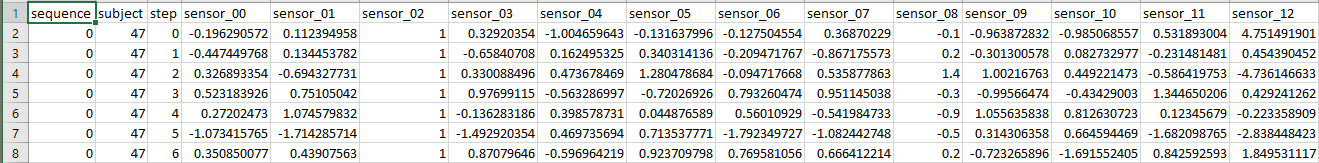

In [3]:
X_train = pd.read_csv("train.csv")
X_train_og = X_train # we will need this for heatmap and pairplot
X_train.shape

(1558080, 16)

In [4]:
X_train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


The "train_lables.csv" file contains the labels for the all the datapoints in "train.csv". It has only two columns: sequence and state.

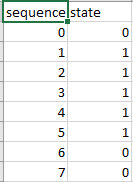

In [5]:
y_train = pd.read_csv("train_labels.csv")
y_train.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [6]:
y_train.shape

(25968, 2)

In [7]:
X_train.describe()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06
mean,1.298350e+04,3.316331e+02,2.950000e+01,4.365526e-04,-1.034982e-03,-2.178045e-01,-2.156555e-03,-1.828903e-03,-1.651785e-03,-4.122917e-04,-2.620665e-05,-1.298393e-04,1.365584e-03,3.315801e-04,-3.733291e-03,-1.172605e-02
std,7.496318e+03,1.958257e+02,1.731811e+01,2.658684e+00,4.404200e+00,2.298002e+00,3.934184e+00,1.683685e+00,1.590818e+00,3.345143e+00,3.243428e+00,4.501534e+00,2.592913e+00,1.917333e+00,4.532568e+00,3.911767e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.750634e+02,-4.345977e+02,-3.165948e+01,-4.083761e+02,-2.362601e+01,-7.498280e+01,-4.705046e+02,-4.070115e+02,-5.361000e+02,-2.703468e+02,-4.341271e+01,-4.270586e+02,-6.125494e+02
25%,6.491750e+03,1.617500e+02,1.475000e+01,-5.000000e-01,-4.831933e-01,-6.461531e-01,-4.929204e-01,-4.729928e-01,-4.786836e-01,-4.927140e-01,-5.022901e-01,-5.000000e-01,-5.151734e-01,-4.787939e-01,-4.835391e-01,-5.805627e-01
50%,1.298350e+04,3.350000e+02,2.950000e+01,-3.091190e-03,3.151261e-03,0.000000e+00,0.000000e+00,-1.589577e-03,2.991773e-03,9.107468e-04,-2.290076e-03,0.000000e+00,-1.445087e-03,-1.655822e-03,3.086420e-03,0.000000e+00
75%,1.947525e+04,5.010000e+02,4.425000e+01,4.845440e-01,4.926471e-01,3.338469e-01,4.893805e-01,4.701565e-01,5.056096e-01,4.927140e-01,4.847328e-01,5.000000e-01,5.086705e-01,4.780386e-01,4.938272e-01,5.703325e-01
max,2.596700e+04,6.710000e+02,5.900000e+01,3.358246e+02,4.495914e+02,1.666667e+00,4.366504e+02,2.487286e+01,7.791548e+01,4.425009e+02,3.312542e+02,6.301000e+02,3.679812e+02,4.186559e+01,4.480206e+02,6.305111e+02


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


Let us check if our dataset has any missing values.

In [9]:
cols = list(X_train.columns)
print(cols)

['sequence', 'subject', 'step', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']


In [10]:
bool_df = pd.DataFrame(columns=X_train.columns)
for i in cols:
    bool_df[i] = pd.isnull(X_train[i])
    print( np.unique(bool_df[i], return_counts=True) )

(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))


In [11]:
for i in cols:
    print(f" The number of null values for feature '{i}' : {(~bool_df[i]).values.sum()} ")

 The number of null values for feature 'sequence' : 1558080 
 The number of null values for feature 'subject' : 1558080 
 The number of null values for feature 'step' : 1558080 
 The number of null values for feature 'sensor_00' : 1558080 
 The number of null values for feature 'sensor_01' : 1558080 
 The number of null values for feature 'sensor_02' : 1558080 
 The number of null values for feature 'sensor_03' : 1558080 
 The number of null values for feature 'sensor_04' : 1558080 
 The number of null values for feature 'sensor_05' : 1558080 
 The number of null values for feature 'sensor_06' : 1558080 
 The number of null values for feature 'sensor_07' : 1558080 
 The number of null values for feature 'sensor_08' : 1558080 
 The number of null values for feature 'sensor_09' : 1558080 
 The number of null values for feature 'sensor_10' : 1558080 
 The number of null values for feature 'sensor_11' : 1558080 
 The number of null values for feature 'sensor_12' : 1558080 


The ".isnull" function is used check if any value in the particular column / series / feature is not missing values. This function/method returns boolean values. All these values are stored in the another dataframe "bool_df". If there are no missing values, then the series for each feature will contain only false values.

The "np.unique()" function is used to count if there are any True values. As we can see from the results above, there is only one unique values that is False. 

Just to be sure, we also use "~pd.values.sum()" to check the number of False values. It should match with our number of datapoints i.e. 1558080. Without the ~ sign the values or count of True values is returned.

In [12]:
X_train[cols].isna().sum()

sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

Another way to check if the dataset has null values or missing values is to use `df.isna().sum()`. This gives us the total number of missing values. As we can see from the cell above none of the features have missing values.

In [13]:
X_train = X_train.drop(columns=['subject','step'])
X_train = X_train.groupby(['sequence']).mean()
y_seq = y_train['sequence']
y_train = y_train.drop(columns=['sequence'])

In [14]:
dc = DummyClassifier()
result_dict = {} 
dc.fit(X_train,y_train)

DummyClassifier()

We also need to check if the testing set has any missing values.

In [15]:
X_test = pd.read_csv("test.csv")
X_test_og = X_test # we may need this for heatmap and pariplot
X_test = X_test.drop(columns=['subject','step'])
X_test.isna().sum()



sequence     0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

From the result above, we can conclude that we do not have any missgin values in the testing set.

It is necessary to group the test set by sequence number just like we did it for training set.

In [16]:
X_test = X_test.groupby(['sequence']).mean() 
# X_test
predict_dc = dc.predict(X_test)
predict_dc_df = pd.DataFrame(predict_dc,columns=['state']) # creating a dataframe of the results
# predict_df

In [17]:
list = []
i = 1
while i < 12219:
    list.append(25967+i)
    i += 1
col = np.array(list)
col_df = pd.DataFrame(col,columns=['sequence']) # creating a dataframe for sequence numbers. This df will be the same for
# all classifiers.

# col_df

final_dc_df = pd.concat([col_df,predict_dc_df],ignore_index=False, sort=False,axis=1) # concating the 
# final_df

In [18]:
final_dc_df.to_csv("Results/output_dummy.csv",index=False) # output the result to csv file

result_dict["Dummy_Classifer"] = mean_std_cross_val_scores(dc, X_train, y_train, cv=5, return_train_score=True)

### Decision Tree Classifier

In [19]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
predict_dtc = dtc.predict(X_test)
predict_dtc_df = pd.DataFrame(predict_dtc,columns=['state']) # creating a dataframe of the results

In [20]:
final_dtc_df = pd.concat([col_df,predict_dtc_df],ignore_index=False, sort=False,axis=1)
final_dtc_df.to_csv("Results/output_dtc.csv",index=False)
result_dict["DecitionTree_Classifier"] = mean_std_cross_val_scores(dtc, X_train, y_train, cv=5, return_train_score=True)

### More Prepocessing

We only checked if the data had any missing values. We also need to check if the features are correlated. Although, it seems logical to assume that no two sensors can affect each other, it is quite possible that they may have some correlation between them.

We will try to create a heatmap and pairplot of the data to see correlation.

In [21]:
import seaborn as sns

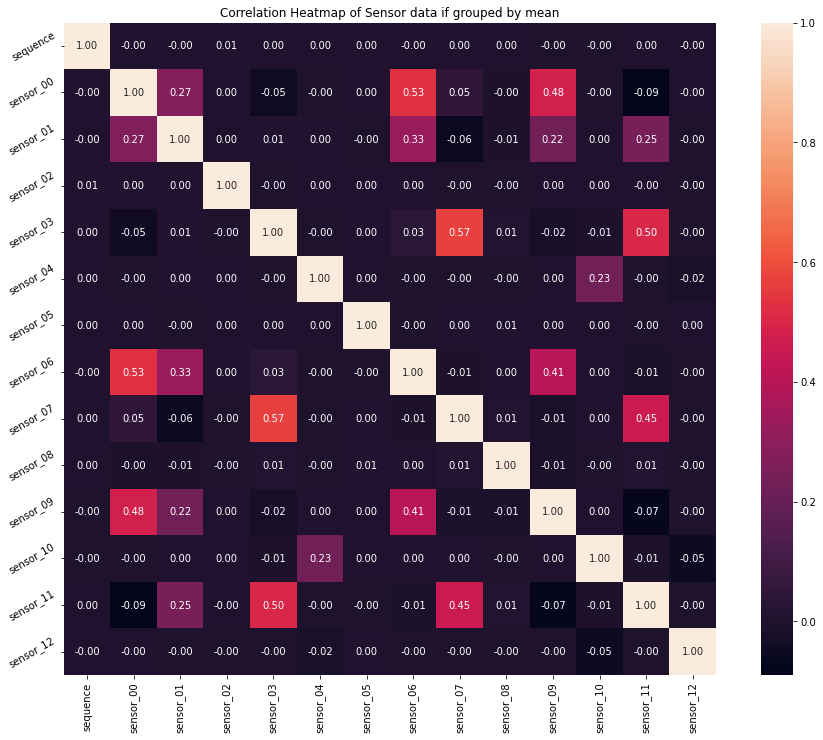

In [22]:
X_train_og = X_train_og.drop(columns=['subject','step'])
# X_train_og
X_train_og.groupby(['sequence']).mean()
correlation = X_train_og.corr()

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Sensor data if grouped by mean')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

As we can see from the sensor heatmap, most sensors do not have significant correlation with each other. Sensors with correlation between 0.2 and 0.55, can be attributes to sensor noise. 

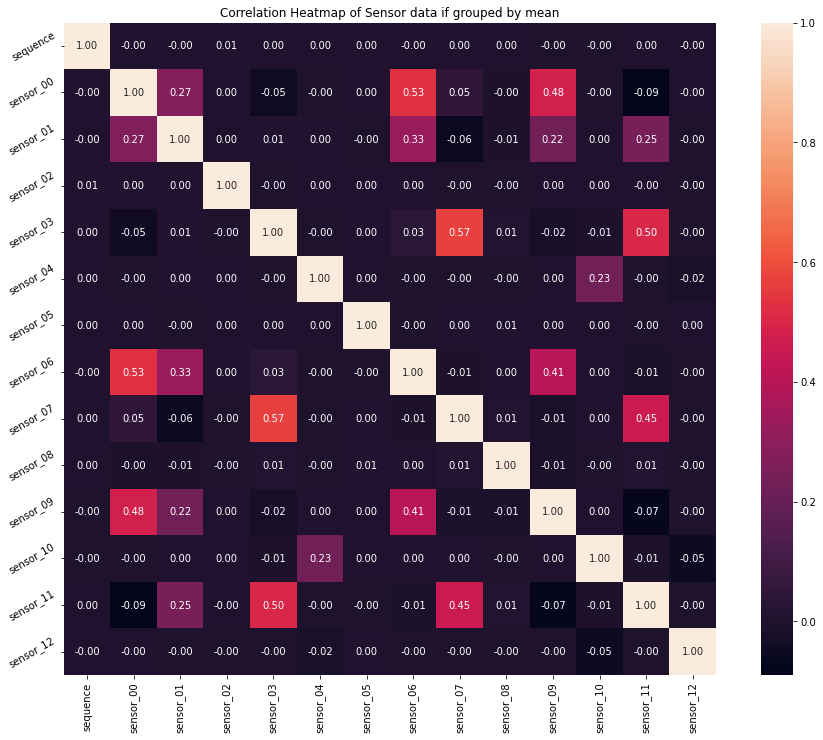

In [23]:
X_train_og.groupby(['sequence']).median()
correlation = X_train_og.corr()

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Sensor data if grouped by mean')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

There is no difference if we group the data by mean or median. Hence it is safe to assume that classifier behaviour won't change much.
We can learn more about the nature of sensor noise if we plotted the frequency histogram. Let us do that in the next step.

In [24]:
cols_og = X_train_og.columns.values.tolist()
cols_og.remove('sequence')
print(cols_og)

['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']


# Run only on Palmetto for graph purposes

In [25]:
# %matplotlib notebook
# a = X_train_og[cols_og[1]].value_counts(bins=800,sort=False).to_frame()
# a.plot()
# plt.xticks(rotation=60);
# plt.subplots_adjust(top=0.925, 
#                     bottom=0.30, 
#                     left=0.2, 
#                     right=0.90, 
#                     hspace=0.01, 
#                     wspace=0.01)
# plt.show()

## Other Classfiers

In [26]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.004 (+/- 0.000),0.002 (+/- 0.002),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.358 (+/- 0.031),0.002 (+/- 0.002),0.612 (+/- 0.004),1.000 (+/- 0.000)


We can see that Decision tree classifier is overfitting. Let us try different models and see if we see better test scores and train scores.
#### Naive Bayes
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [27]:
#Naive bayes
gnb = GaussianNB()
gnb.fit(X_train,y_train)
predict_gnb = gnb.predict(X_test)
predict_gnb_df = pd.DataFrame(predict_gnb,columns=['state']) # creating a dataframe of the results

final_gnb_df = pd.concat([col_df,predict_gnb_df],ignore_index=False, sort=False,axis=1)
final_gnb_df.to_csv("Results/output_gnb.csv",index=False)
result_dict["GNB_Classifier"] = mean_std_cross_val_scores(gnb, X_train, y_train, cv=5, return_train_score=True)

In [28]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.004 (+/- 0.000),0.002 (+/- 0.002),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.358 (+/- 0.031),0.002 (+/- 0.002),0.612 (+/- 0.004),1.000 (+/- 0.000)
GNB_Classifier,0.010 (+/- 0.002),0.002 (+/- 0.002),0.601 (+/- 0.008),0.602 (+/- 0.009)


#### Logistic Regression

In [29]:
#Logistic Regression
lr = LogisticRegression(random_state=1)
lr.fit(X_train,y_train)
predict_lr = lr.predict(X_test)
predict_lr_df = pd.DataFrame(predict_lr,columns=['state']) # creating a dataframe of the results

final_lr_df = pd.concat([col_df,predict_lr_df],ignore_index=False, sort=False,axis=1)
final_lr_df.to_csv("Results/output_lr.csv",index=False)
result_dict["LogisticR_Classifier"] = mean_std_cross_val_scores(lr, X_train, y_train, cv=5, return_train_score=True)

In [30]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.004 (+/- 0.000),0.002 (+/- 0.002),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.358 (+/- 0.031),0.002 (+/- 0.002),0.612 (+/- 0.004),1.000 (+/- 0.000)
GNB_Classifier,0.010 (+/- 0.002),0.002 (+/- 0.002),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.097 (+/- 0.047),0.001 (+/- 0.002),0.547 (+/- 0.006),0.548 (+/- 0.002)


#### Random Forest Classifier

In [31]:
#Random Forest
rf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state=0)
rf.fit(X_train,y_train)

predict_rf = rf.predict(X_test)
predict_rf_df = pd.DataFrame(predict_rf,columns=['state']) # creating a dataframe of the results

final_rf_df = pd.concat([col_df,predict_rf_df],ignore_index=False, sort=False,axis=1)
final_rf_df.to_csv("Results/output_rf.csv",index=False)
result_dict["RandomForest_Classifier"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)

In [32]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.004 (+/- 0.000),0.002 (+/- 0.002),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.358 (+/- 0.031),0.002 (+/- 0.002),0.612 (+/- 0.004),1.000 (+/- 0.000)
GNB_Classifier,0.010 (+/- 0.002),0.002 (+/- 0.002),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.097 (+/- 0.047),0.001 (+/- 0.002),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,5.337 (+/- 2.365),0.119 (+/- 0.063),0.701 (+/- 0.006),0.786 (+/- 0.002)


#### Gradient Boosting Classifier

In [33]:
#Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
gbc.fit(X_train,y_train)

predict_gbc = gbc.predict(X_test)
predict_gbc_df = pd.DataFrame(predict_gbc,columns=['state']) # creating a dataframe of the results

final_gbc_df = pd.concat([col_df,predict_gbc_df],ignore_index=False, sort=False,axis=1)
final_gbc_df.to_csv("Results/output_gbc.csv",index=False)
result_dict["GradBoost_Classifier"] = mean_std_cross_val_scores(gbc, X_train, y_train, cv=5, return_train_score=True)

In [34]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.004 (+/- 0.000),0.002 (+/- 0.002),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.358 (+/- 0.031),0.002 (+/- 0.002),0.612 (+/- 0.004),1.000 (+/- 0.000)
GNB_Classifier,0.010 (+/- 0.002),0.002 (+/- 0.002),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.097 (+/- 0.047),0.001 (+/- 0.002),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,5.337 (+/- 2.365),0.119 (+/- 0.063),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.733 (+/- 0.272),0.005 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)


In [35]:
#Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
gbc.fit(X_train,y_train)

predict_gbc = gbc.predict_proba(X_test)
predict_gbc_proba = []
for i in range(len(predict_gbc)):
    predict_gbc_proba.append(predict_gbc[i][1])

predict_gbc_df = pd.DataFrame(predict_gbc_proba,columns=['state']) # creating a dataframe of the results
final_gbc_df = pd.concat([col_df,predict_gbc_df],ignore_index=False, sort=False,axis=1)
final_gbc_df.to_csv("Results/output_gbc_proba.csv",index=False)


result_dict["GradBoost_Classifier_delete"] = mean_std_cross_val_scores(gbc, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(result_dict).T

ValueError: Shape of passed values is (12218, 2), indices imply (12218, 1)

In [42]:
predict_gbc_test = []
for i in range(len(predict_gbc)):
    predict_gbc_test.append(predict_gbc[i][1])

In [44]:
predict_gbc_test

